In [1]:
import gymnasium as gym
import cookiedisaster
import numpy as np
import random
import matplotlib.pyplot as plt
from CookieAgent import CookieAgent

SEED=2
np.random.seed(SEED)
random.seed(SEED)

In [2]:
def train_on_environments(envs, num_episodes_per_env=20, gamma=0.99):
    results = {}
    agent_parameters = {'input_dim': 6, 'output_dim': envs[0].action_space.n, 'epsilon':0.5}
    agent = CookieAgent(**agent_parameters)
    
    for i in range(len(envs)):
        env = envs[i]
        episode_rewards = []
        for episode in range(num_episodes_per_env):
            state = env.reset()[0]
            # print('state',state)
            if episode==0:
                agent.update_env(state)
            # state = preprocess_state(state)
            done = False
            total_reward = 0
            count = 0
            while not done:
                if count > agent.MAX_TIME:
                    # print('time out')
                    break
                count+=1
                action = agent.select_action(state)
                next_state, reward, done, _, _ = env.step(action)
                # print('next_state',next_state)
                # next_state = preprocess_state(next_state)

                agent.learn(state, reward, next_state, done)
                state = next_state
                total_reward += reward

            episode_rewards.append(total_reward)
            # print('ep,end')
            if episode % 10 == 0:
                print(f"Environment {i}: Episode {episode} Reward: {total_reward}")
        
        results[i] = episode_rewards
    return results, agent


envs = [
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.1}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.1}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 10, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.1}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.1}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.1}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 5, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.1}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":5, "friction": lambda vel: - abs(vel)*vel * 0.1}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":4, "friction": lambda vel: - abs(vel)*vel * 0.1}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.05}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.08}),
    gym.make('cookiedisaster-v1',config={"img": "cake","width" : 12, "lifetime":7, "friction": lambda vel: - abs(vel)*vel * 0.1}),
]

nr_envs = 50

widths=[np.random.randint(1,21) for _ in range(nr_envs)]
lifetimes=[np.random.randint(3,11) for _ in range(nr_envs)]
frictions=[round(np.random.uniform(0.01,0.3),2) for _ in range(nr_envs)]
add_envs=[]
for i in range(nr_envs):
    add_envs.append(gym.make('cookiedisaster-v1',config={"img": "cake","width" : widths[i], "lifetime":lifetimes[i], "friction": lambda vel: - abs(vel)*vel * frictions[i]}))

envs=envs+add_envs
random.shuffle(envs)

all_env_results,agent = train_on_environments(envs, num_episodes_per_env=5)

# Optionally, print or plot the results for each environment
for env_name, rewards in all_env_results.items():
    print(f"Results for {env_name}: Average Reward: {sum(rewards) / len(rewards)}")


c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:131: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'dict'>
  logger.warn(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\spaces\box.py:240: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\utils\passive_env_check

Environment 0: Episode 0 Reward: -6.4056970967441975
Environment 1: Episode 0 Reward: 18.728262991097516
Environment 2: Episode 0 Reward: 20.981325577881602
Environment 3: Episode 0 Reward: 24.14948455284944
Environment 4: Episode 0 Reward: 43.51140224068547
Environment 5: Episode 0 Reward: 23
Environment 6: Episode 0 Reward: 45.5888018215773
Environment 7: Episode 0 Reward: 24.0
Environment 8: Episode 0 Reward: 28.154511719439576
Environment 9: Episode 0 Reward: 23.543474388892253
Environment 10: Episode 0 Reward: 33.19115359561985
Environment 11: Episode 0 Reward: 22
Environment 12: Episode 0 Reward: 36.7766936209675
Environment 13: Episode 0 Reward: 19.484982444398938
Environment 14: Episode 0 Reward: 64.96803974080215
Environment 15: Episode 0 Reward: 34.81330535860296
Environment 16: Episode 0 Reward: 22.73298880597514
Environment 17: Episode 0 Reward: 7.0
Environment 18: Episode 0 Reward: 42.246849974382734
Environment 19: Episode 0 Reward: 49.868062068750135
Environment 20: Epis

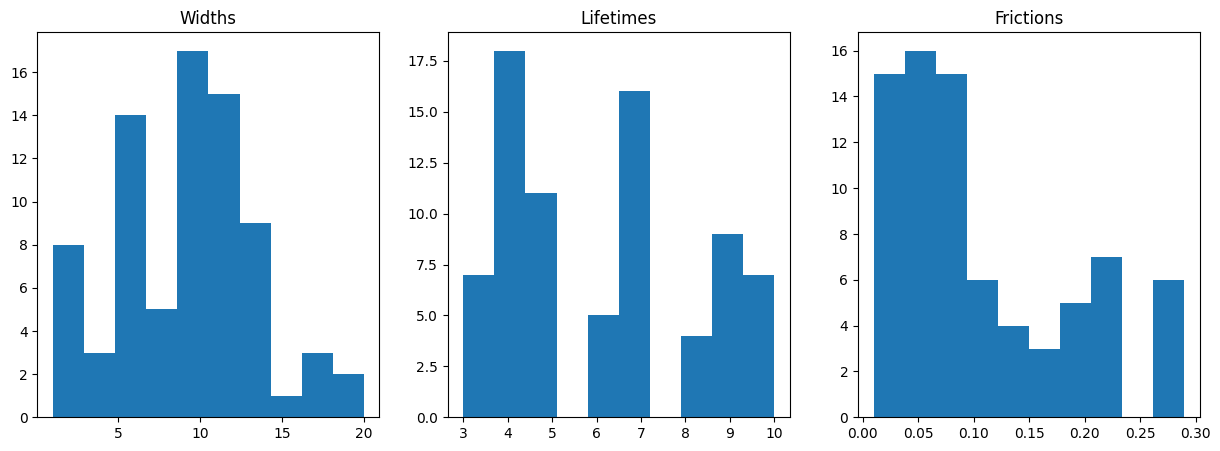

In [3]:
widths=widths+[10,5,12]*9
lifetimes=lifetimes+[5,4,7]*9
frictions=frictions+[0.05,0.08,0.01]*9

fig,ax=plt.subplots(1,3,figsize=(15,5))
ax[0].hist(widths)
ax[0].set_title('Widths')
ax[1].hist(lifetimes)
ax[1].set_title('Lifetimes')
ax[2].hist(frictions)
ax[2].set_title('Frictions')

plt.show()


In [5]:
agent.save('cookie_patrol_agent.pth')

In [6]:
properAgent = CookieAgent(save_path='cookie_patrol_agent.pth')


In [8]:
def test_agent(agent, env, num_episodes=150):
    rewards = []
    agent_pos=[]
    cookie_pos=[]
    state = env.reset()[0]
    # update_env(state)
    # state = preprocess_state(state)
    total_reward = 0
    for _ in range(num_episodes):
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent_pos.append(next_state['agent']['pos'])
        cookie_pos.append(next_state['cookie']['pos'])
        # next_state = preprocess_state(next_state)
        state = next_state
        total_reward += reward
        rewards.append(total_reward)
    env.close()
    return rewards,agent_pos,cookie_pos


cookie_1 = gym.make('cookiedisaster-v1')  
cookie_2 = gym.make('cookiedisaster-v2')
cookie_3 = gym.make('cookiedisaster-v3')
rewards=[]
agent_poss=[]
cookie_poss=[]
envs = [cookie_1, cookie_2, cookie_3]
for env in envs:
    properAgent = CookieAgent(save_path='cookie_patrol_agent.pth')

    print(properAgent.ENV_LIFETIME,properAgent.ENV_WIDTH,properAgent.MAX_TIME,properAgent.count)
    rew,ag,cooki=test_agent(properAgent, env)
    rewards.append(rew)
    agent_poss.append(ag)
    cookie_poss.append(cooki)
    print(properAgent.ENV_LIFETIME,properAgent.ENV_WIDTH,properAgent.MAX_TIME,properAgent.count)
    print(f"Results for {env.spec.id}: Average Reward: {sum(rewards[-1]) / len(rewards[-1])}")


c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v1 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(
c:\Users\saraa\anaconda3\envs\inf368\Lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment cookiedisaster-v2 is out of date. You should consider upgrading to version `v3`.
  logger.deprecation(


5 10 250 0
5 10.0 250 1
Results for cookiedisaster-v1: Average Reward: 7.5434483814544
5 10 250 0
4 5.0 200 1
Results for cookiedisaster-v2: Average Reward: 11.607539862354225
5 10 250 0
7 12.0 350 1
Results for cookiedisaster-v3: Average Reward: 10.946532821184187


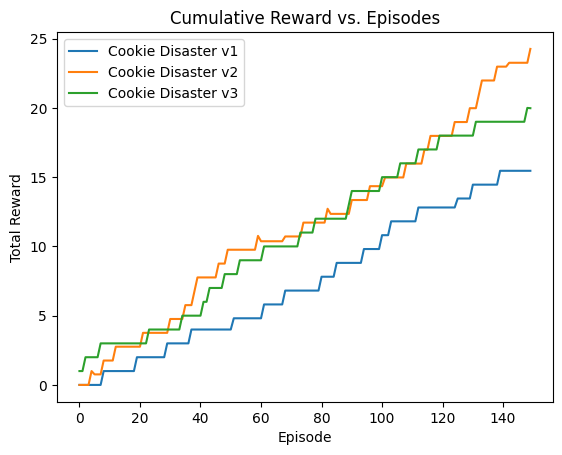

In [9]:
plt.plot(rewards[0], label='Cookie Disaster v1')
plt.plot(rewards[1], label='Cookie Disaster v2')
plt.plot(rewards[2], label='Cookie Disaster v3')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Cumulative Reward vs. Episodes')
plt.legend()
plt.show()

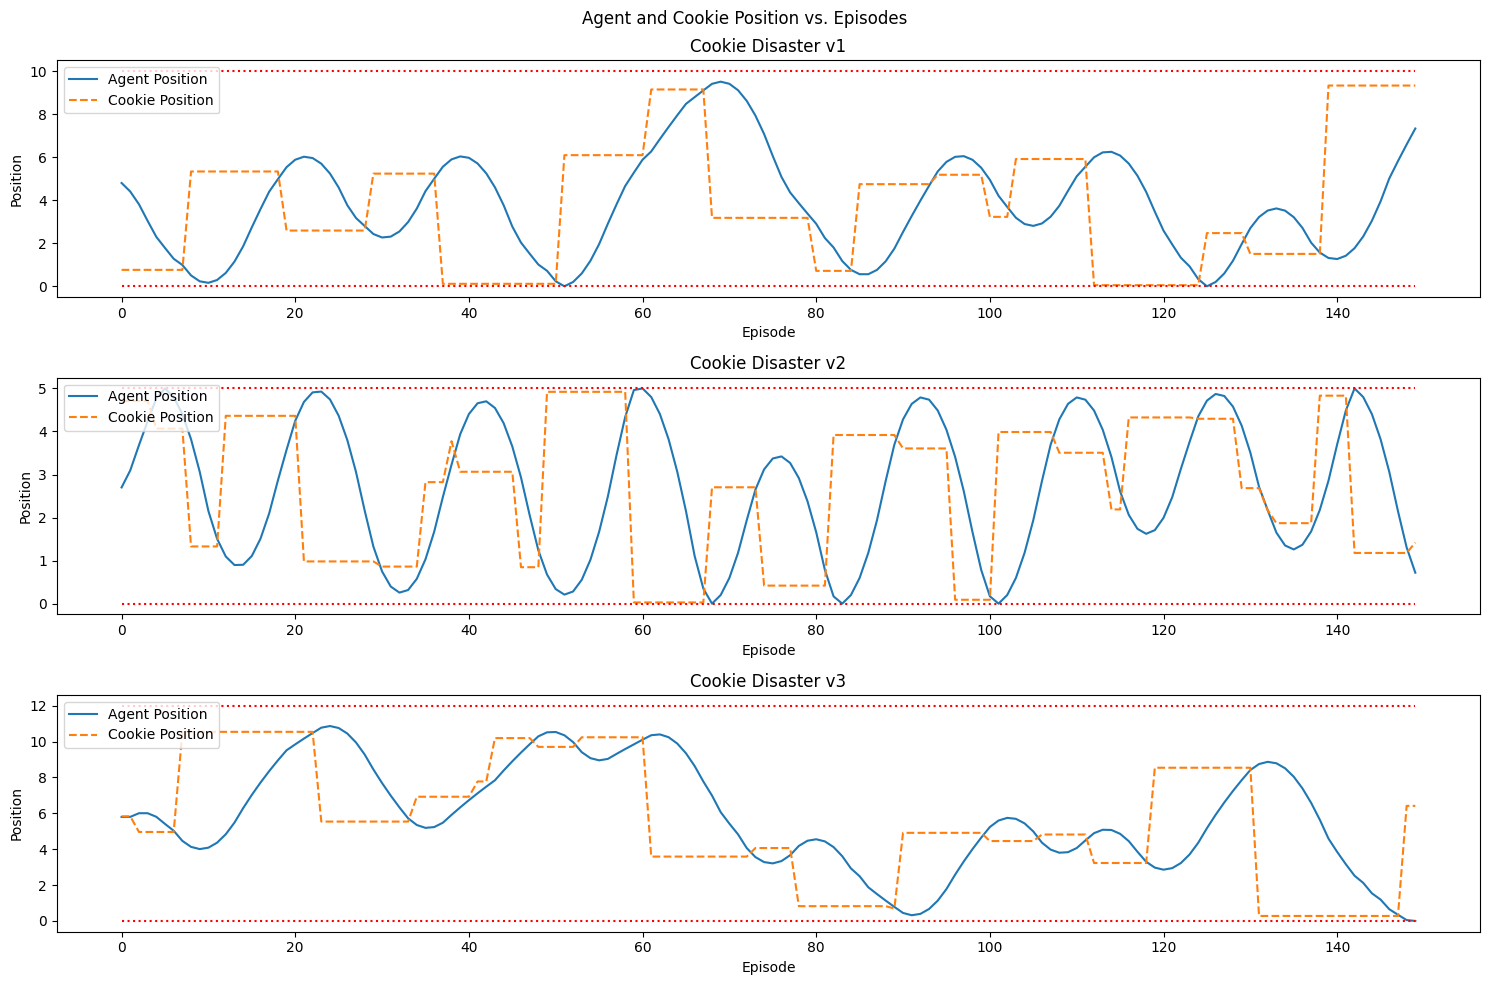

In [10]:
fig,ax=plt.subplots(3,1,figsize=(15,10))
ax[0].plot(agent_poss[0], label='Agent Position')
ax[0].plot(cookie_poss[0], label='Cookie Position',linestyle='dashed')
ax[0].plot([0]*len(agent_poss[0]),linestyle='dotted',color='red')
ax[0].plot([10]*len(agent_poss[0]),linestyle='dotted',color='red')
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Position')
ax[0].legend(loc='upper left')
ax[0].set_title('Cookie Disaster v1')


ax[1].plot(agent_poss[1], label='Agent Position')
ax[1].plot(cookie_poss[1], label='Cookie Position',linestyle='dashed')
ax[1].plot([0]*len(agent_poss[1]),linestyle='dotted',color='red')
ax[1].plot([5]*len(agent_poss[1]),linestyle='dotted',color='red')
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Position')
ax[1].legend(loc='upper left')
ax[1].set_title('Cookie Disaster v2')


ax[2].plot(agent_poss[2], label='Agent Position')
ax[2].plot(cookie_poss[2], label='Cookie Position',linestyle='dashed')
ax[2].plot([0]*len(agent_poss[2]),linestyle='dotted',color='red')
ax[2].plot([12]*len(agent_poss[2]),linestyle='dotted',color='red')
ax[2].set_xlabel('Episode')
ax[2].set_ylabel('Position')
ax[2].legend(loc='upper left')
ax[2].set_title('Cookie Disaster v3')


fig.suptitle('Agent and Cookie Position vs. Episodes')

plt.tight_layout()
plt.show()


In [11]:
# env=gym.make('cookiedisaster-v1',config={"img": "cake","width" : 20, "lifetime":8, "friction": lambda vel: - abs(vel)*vel * 1.3},render_mode='human')

In [12]:
# properAgent = CookieAgent()
# properAgent.load('cookie_patrol_agent.pth')

In [13]:
# test_agent(properAgent,env)

In [14]:
# env.render()

In [15]:
# env.close()

In [16]:
# env.step(0)